### **ANIMAL CLASSIFICATION USING CNN**


In [32]:
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns

### **Apply Transformations to Validation Images**
- Blurring: Apply Gaussian blur to each image.
- Rotation: Rotate each image by 180 degrees.
- Brightness Adjustment: Increase or decrease brightness.

In [22]:
# Paths for original validation directory and transformed directory
val_dir = 'D:/DePaul/Depaul/Quarter 4/Introduction to Image Processing/Project/Animal Classification/Image files/val'
transformed_dir = 'D:/DePaul/Depaul/Quarter 4/Introduction to Image Processing/Project/Animal Classification/Image files/transformed_val'

# Categories of animals
categories = ['cat', 'dog', 'wild']

# Transformation types and their specific parameters
transformation_params = {
    'blurred': [(9, 9), (13, 13), (17, 17), (21, 21)],
    'brightened': [0.2, 0.5, 1.5, 1.8],
    'rotated': [90, 180],
    'noise': [
        {'type': 'gaussian', 'std': 25},
        {'type': 'salt_pepper', 'amount': 0.02, 'salt_vs_pepper': 0.5},
        {'type': 'speckle'}
    ]
}

# List of transformation names
transform_types = list(transformation_params.keys())


In [23]:
for kernel in transformation_params['blurred']:
    for category in categories:
        os.makedirs(os.path.join(transformed_dir, f'blurred_{kernel[0]}x{kernel[1]}', category), exist_ok=True)

for factor in transformation_params['brightened']:
    for category in categories:
        os.makedirs(os.path.join(transformed_dir, f'brightened_{factor}', category), exist_ok=True)

for angle in transformation_params['rotated']:
    for category in categories:
        os.makedirs(os.path.join(transformed_dir, f'rotated_{angle}', category), exist_ok=True)

for noise in transformation_params['noise']:
    noise_type = noise['type']
    folder_name = f"noise_{noise_type}"
    for category in categories:
        os.makedirs(os.path.join(transformed_dir, folder_name, category), exist_ok=True)

In [24]:
def add_salt_pepper_noise(image, amount=0.02, salt_vs_pepper=0.5):
    output = np.copy(image)
    h, w = image.shape[:2]

    # Salt
    num_salt = int(np.ceil(amount * image.size * salt_vs_pepper))
    coords = [np.random.randint(0, i - 1, num_salt) for i in (h, w)]
    output[coords[0], coords[1]] = 255

    # Pepper
    num_pepper = int(np.ceil(amount * image.size * (1.0 - salt_vs_pepper)))
    coords = [np.random.randint(0, i - 1, num_pepper) for i in (h, w)]
    output[coords[0], coords[1]] = 0

    return output


In [25]:
def apply_transformations(image_path, filename, category):
    image = cv2.imread(image_path)
    pil_image = Image.open(image_path)

    # 1. Apply Gaussian Blur
    for kernel in transformation_params['blurred']:
        blurred = cv2.GaussianBlur(image, kernel, 0)
        folder = f'blurred_{kernel[0]}x{kernel[1]}'
        path = os.path.join(transformed_dir, folder, category, f'blurred_{kernel[0]}x{kernel[1]}_{filename}')
        cv2.imwrite(path, blurred)

    # 2. Adjust Brightness
    for factor in transformation_params['brightened']:
        enhancer = ImageEnhance.Brightness(pil_image)
        brightened = enhancer.enhance(factor)
        folder = f'brightened_{factor}'
        path = os.path.join(transformed_dir, folder, category, f'brightened_{factor}_{filename}')
        brightened.save(path)

    # 3. Rotate
    for angle in transformation_params['rotated']:
        if angle == 90:
            rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        elif angle == 180:
            rotated = cv2.rotate(image, cv2.ROTATE_180)
        else:
            continue
        folder = f'rotated_{angle}'
        path = os.path.join(transformed_dir, folder, category, f'rotated_{angle}_{filename}')
        cv2.imwrite(path, rotated)

    # 4. Add Noise (multiple types supported)
    for noise_config in transformation_params['noise']:
        noise_type = noise_config['type']
        folder = f'noise_{noise_type}'

        if noise_type == 'gaussian':
            std = noise_config.get('std', 25)
            noise = np.random.normal(0, std, image.shape).astype(np.uint8)
            noisy = cv2.add(image, noise)
            path = os.path.join(transformed_dir, folder, category, f'noisy_gaussian_std{std}_{filename}')
            cv2.imwrite(path, noisy)

        elif noise_type == 'salt_pepper':
            amount = noise_config.get('amount', 0.02)
            ratio = noise_config.get('salt_vs_pepper', 0.5)
            noisy = add_salt_pepper_noise(image, amount, ratio)
            path = os.path.join(transformed_dir, folder, category, f'noisy_saltpepper_{filename}')
            cv2.imwrite(path, noisy)

        elif noise_type == 'speckle':
            noise = np.random.randn(*image.shape)
            noisy = image + image * noise
            noisy = np.clip(noisy, 0, 255).astype(np.uint8)
            path = os.path.join(transformed_dir, folder, category, f'noisy_speckle_{filename}')
            cv2.imwrite(path, noisy)


In [26]:
# Apply transformations to all images in each category
for category in categories:
    category_path = os.path.join(val_dir, category)
    print(f"Processing category: {category}")
    for filename in tqdm(os.listdir(category_path), desc=f"{category}"):
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        file_path = os.path.join(category_path, filename)
        apply_transformations(file_path, filename, category)

Processing category: cat


cat: 100%|██████████| 500/500 [00:44<00:00, 11.18it/s]


Processing category: dog


dog: 100%|██████████| 500/500 [00:44<00:00, 11.33it/s]


Processing category: wild


wild: 100%|██████████| 500/500 [00:43<00:00, 11.41it/s]


### **Train the ML Model**
Using Convolutional neural network (CNN) for this task. Steps include:
- Define and compile the model.
- Train it using the original Val images.
- Save the trained model for reuse.

In [12]:
# TensorFlow and Keras components
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [14]:
# Define paths
train_dir = 'D:/DePaul/Depaul/Quarter 4/Introduction to Image Processing/Project/Animal Classification/Image files/train'

# Image Data Generator for loading the images (no validation_split needed)
datagen = ImageDataGenerator(rescale=1.0/255)

# Training generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  # Resize images to a consistent size
    batch_size=32,
    class_mode='categorical'
)

# Validation generator
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Check class label mappings
print("Class indices:", train_generator.class_indices)


Found 14630 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Class indices: {'cat': 0, 'dog': 1, 'wild': 2}


##### 3. Define and Compile the Model:

In [15]:
# Define a Convolutional Neural Network (CNN) model
model = Sequential([

    # First convolutional layer: 32 filters, 3x3 kernel, ReLU activation
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    
    # First max pooling layer: reduces spatial dimensions by 2x
    MaxPooling2D((2, 2)),

    # Second convolutional layer: 64 filters, learns deeper features
    Conv2D(64, (3, 3), activation='relu'),
    
    # Second max pooling layer
    MaxPooling2D((2, 2)),

    # Third convolutional layer: 128 filters for more complex patterns
    Conv2D(128, (3, 3), activation='relu'),
    
    # Third max pooling layer
    MaxPooling2D((2, 2)),

    # Flatten the 3D feature maps into a 1D vector
    Flatten(),

    # Fully connected dense layer with 128 neurons
    Dense(128, activation='relu'),

    # Output layer with 3 neurons (for cat, dog, wild) and softmax activation
    Dense(3, activation='softmax')
])

# Compile the model with Adam optimizer and categorical crossentropy loss
# - 'accuracy' metric will be used to monitor performance
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


c:\Users\aksh0\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
epochs = 10  

model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

model.save('animal_classifier_model.h5')

c:\Users\aksh0\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 217s 468ms/step - accuracy: 0.6949 - loss: 0.6546 - val_accuracy: 0.9453 - val_loss: 0.1734
Epoch 2/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 58s 127ms/step - accuracy: 0.9568 - loss: 0.1239 - val_accuracy: 0.9480 - val_loss: 0.1382
Epoch 3/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 639s 1s/step - accuracy: 0.9739 - loss: 0.0747 - val_accuracy: 0.9547 - val_loss: 0.1346
Epoch 4/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 61s 133ms/step - accuracy: 0.9806 - loss: 0.0527 - val_accuracy: 0.9633 - val_loss: 0.1165
Epoch 5/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 63s 136ms/step - accuracy: 0.9863 - loss: 0.0366 - val_accuracy: 0.9693 - val_loss: 0.0871
Epoch 6/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 67s 147ms/step - accuracy: 0.9912 - loss: 0.0258 - val_accuracy: 0.9713 - val_loss: 0.0999
Epoch 7/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 68s 149ms/step - accuracy: 0.9918 - loss: 0.0241 - val_accuracy: 0.9547 - val_loss: 0.1354
Epoch 8/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 68s 148ms/step - accuracy: 0.9939 - loss: 0.

### **Model Evaluation**
- Load the model.
- Select random images from each original and transformed validation folder (blurred, rotated, and brightened) for comparison.
- Display each image along with predictions and the model's confidence for each category (cat, dog, or wild).

In [17]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [18]:
# Load model
model = load_model('animal_classifier_model.h5')

In [27]:
class_labels = ['cat', 'dog', 'wild']

def predict_and_display(images, titles):
    """
    Predicts and displays a row of images with predicted class and confidence.
    """
    plt.figure(figsize=(15, 5))

    for i, (img_path, title) in enumerate(zip(images, titles)):
        try:
            # Load and preprocess the image
            image = load_img(img_path, target_size=(128, 128))
            img_array = img_to_array(image) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            # Make prediction
            prediction = model.predict(img_array, verbose=0)
            predicted_class = class_labels[np.argmax(prediction)]
            confidence = np.max(prediction) * 100

            # Plot the image with prediction
            plt.subplot(1, len(images), i + 1)
            plt.imshow(image)
            plt.axis('off')
            plt.title(f"{title}\nPredicted: {predicted_class} ({confidence:.2f}%)")

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

    plt.tight_layout()
    plt.show()

In [28]:
# Base path for original validation images
original_dir = 'D:/DePaul/Depaul/Quarter 4/Introduction to Image Processing/Project/Animal Classification/Image files/val'

# Paths for each transformation variant
transformed_dirs = {
    # Blurred
    'Blurred_9x9': os.path.join(transformed_dir, 'blurred_9x9'),
    'Blurred_13x13': os.path.join(transformed_dir, 'blurred_13x13'),
    'Blurred_17x17': os.path.join(transformed_dir, 'blurred_17x17'),
    'Blurred_21x21': os.path.join(transformed_dir, 'blurred_21x21'),

    # Brightened
    'Brightened_0.2': os.path.join(transformed_dir, 'brightened_0.2'),
    'Brightened_0.5': os.path.join(transformed_dir, 'brightened_0.5'),
    'Brightened_1.5': os.path.join(transformed_dir, 'brightened_1.5'),
    'Brightened_1.8': os.path.join(transformed_dir, 'brightened_1.8'),

    # Rotated
    'Rotated_90': os.path.join(transformed_dir, 'rotated_90'),
    'Rotated_180': os.path.join(transformed_dir, 'rotated_180'),

    # Noise
    'Noise_Gaussian': os.path.join(transformed_dir, 'noise_gaussian'),
    'Noise_SaltPepper': os.path.join(transformed_dir, 'noise_salt_pepper'),
    'Noise_Speckle': os.path.join(transformed_dir, 'noise_speckle'),
}


In [29]:
# Initialize the data generator for evaluation
eval_datagen = ImageDataGenerator(rescale=1.0/255)

# Include original validation set
all_dirs = {'Original': original_dir}
all_dirs.update(transformed_dirs)

# Store results
results = {}

# Evaluate model on each version
for name, path in all_dirs.items():
    generator = eval_datagen.flow_from_directory(
        path,
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical',
        shuffle=False  # important for consistent evaluation
    )
    
    loss, acc = model.evaluate(generator, verbose=0)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.2%}")


Found 1500 images belonging to 3 classes.
Original Accuracy: 96.93%
Found 1500 images belonging to 3 classes.
Blurred_9x9 Accuracy: 97.00%
Found 1500 images belonging to 3 classes.
Blurred_13x13 Accuracy: 96.53%
Found 1500 images belonging to 3 classes.
Blurred_17x17 Accuracy: 96.27%
Found 1500 images belonging to 3 classes.
Blurred_21x21 Accuracy: 95.60%
Found 1500 images belonging to 3 classes.
Brightened_0.2 Accuracy: 54.47%
Found 1500 images belonging to 3 classes.
Brightened_0.5 Accuracy: 94.93%
Found 1500 images belonging to 3 classes.
Brightened_1.5 Accuracy: 96.20%
Found 1500 images belonging to 3 classes.
Brightened_1.8 Accuracy: 95.67%
Found 1500 images belonging to 3 classes.
Rotated_90 Accuracy: 56.40%
Found 1500 images belonging to 3 classes.
Rotated_180 Accuracy: 64.73%
Found 1500 images belonging to 3 classes.
Noise_Gaussian Accuracy: 63.73%
Found 1500 images belonging to 3 classes.
Noise_SaltPepper Accuracy: 85.20%
Found 1500 images belonging to 3 classes.
Noise_Speckle

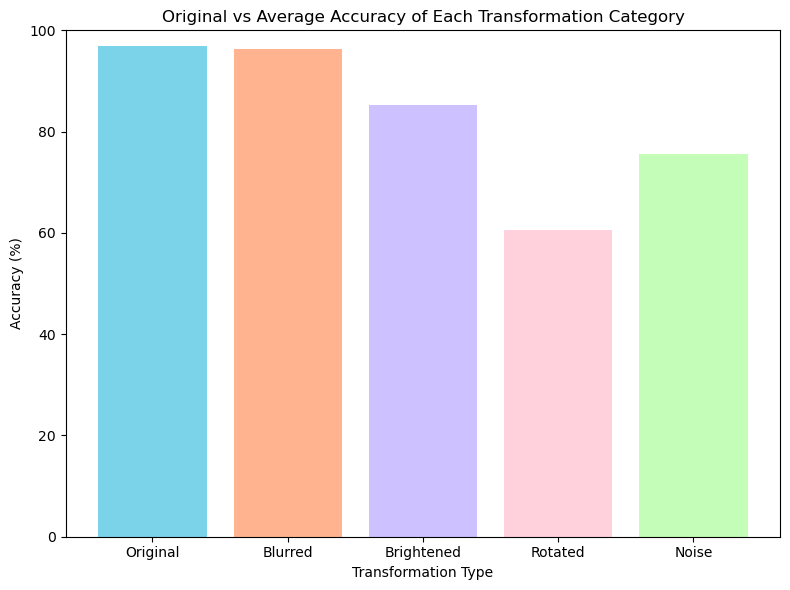

In [36]:
# Grouping transformation types
grouped_results = {
    'Original': results['Original'],
    'Blurred': np.mean([results[k] for k in results if k.startswith('Blurred_')]),
    'Brightened': np.mean([results[k] for k in results if k.startswith('Brightened_')]),
    'Rotated': np.mean([results[k] for k in results if k.startswith('Rotated_')]),
    'Noise': np.mean([results[k] for k in results if k.startswith('Noise_')]),
}

# Create DataFrame
summary_df = pd.DataFrame(list(grouped_results.items()), columns=['Transformation', 'Accuracy'])
summary_df['Accuracy (%)'] = summary_df['Accuracy'] * 100

# Pastel colors for each bar
pastel_colors = ['#7BD3EA', '#FFB38E', '#CDC1FF', '#FFD1DC', '#C3FDB8']  # light blue, orange, cyan, pink, green

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(summary_df['Transformation'], summary_df['Accuracy (%)'], color=pastel_colors)

# Labels and styling
plt.title('Original vs Average Accuracy of Each Transformation Category')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.xlabel('Transformation Type')
plt.tight_layout()
plt.show()


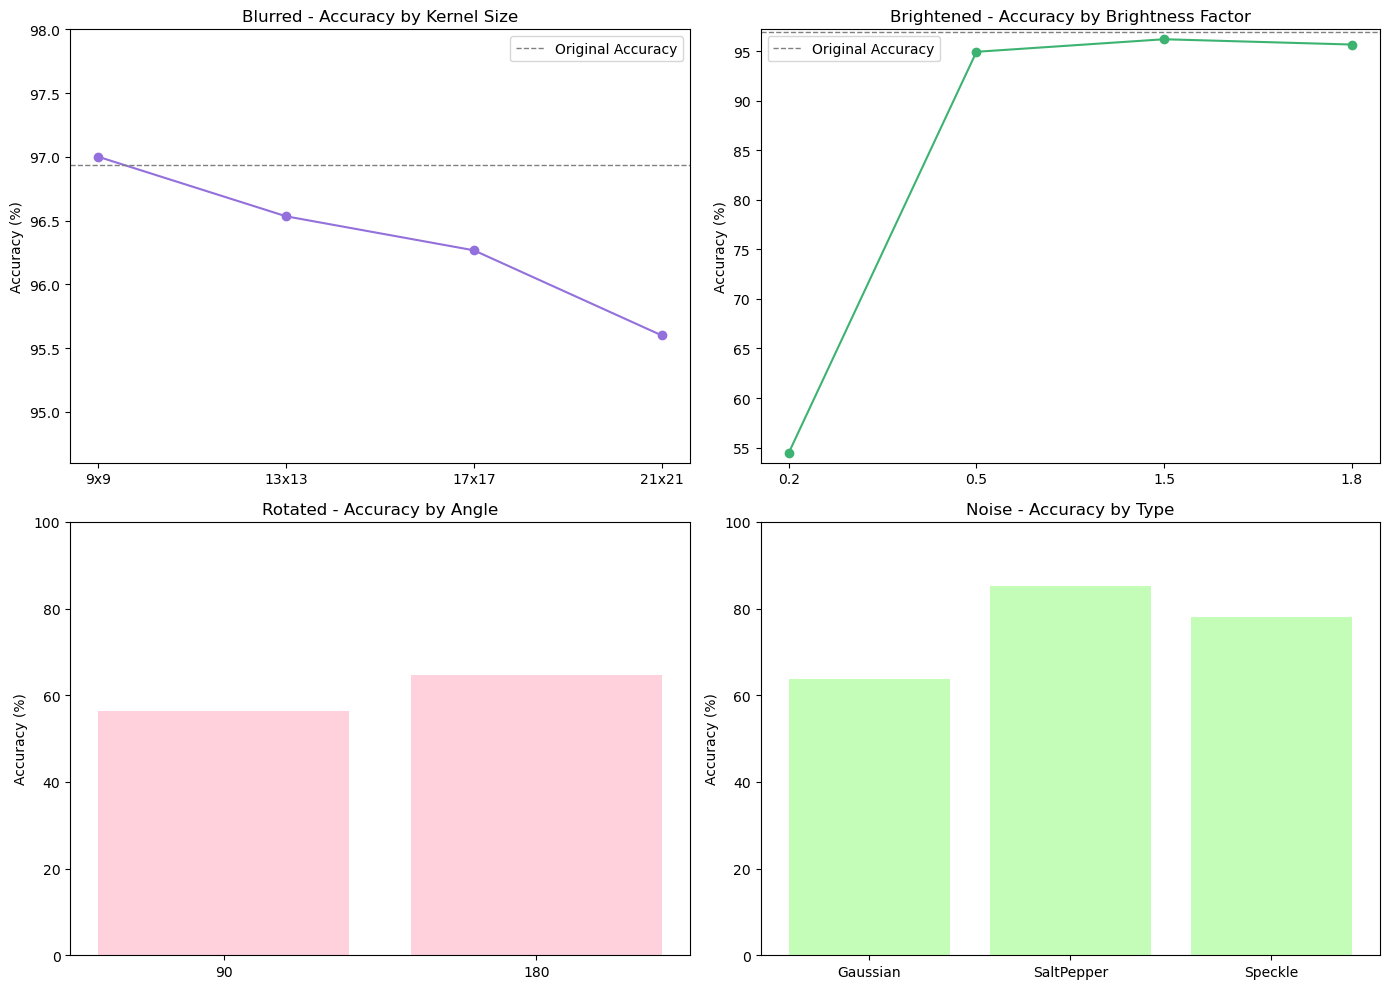

In [40]:
# Prepare accuracy data
blurred_acc = {k.replace('Blurred_', ''): results[k] * 100 for k in results if k.startswith('Blurred_')}
brightened_acc = {k.replace('Brightened_', ''): results[k] * 100 for k in results if k.startswith('Brightened_')}
rotated_acc = {k.replace('Rotated_', ''): results[k] * 100 for k in results if k.startswith('Rotated_')}
noise_acc = {k.replace('Noise_', ''): results[k] * 100 for k in results if k.startswith('Noise_')}

# Create 2x2 subplot
plt.figure(figsize=(14, 10))

# 1. Blurred (Line chart)
plt.subplot(2, 2, 1)
x = list(blurred_acc.keys())
y = list(blurred_acc.values())
plt.plot(x, y, marker='o', linestyle='-', color='mediumpurple')
plt.axhline(results['Original'] * 100, color='gray', linestyle='--', linewidth=1, label='Original Accuracy')
plt.title("Blurred - Accuracy by Kernel Size")
plt.ylabel("Accuracy (%)")
plt.ylim(min(y) - 1, max(y) + 1)
plt.legend()

# 2. Brightened (Line chart)
plt.subplot(2, 2, 2)
x = list(brightened_acc.keys())
y = list(brightened_acc.values())
plt.plot(x, y, marker='o', linestyle='-', color='mediumseagreen')
plt.axhline(results['Original'] * 100, color='gray', linestyle='--', linewidth=1, label='Original Accuracy')
plt.title("Brightened - Accuracy by Brightness Factor")
plt.ylabel("Accuracy (%)")
plt.ylim(min(y) - 1, max(y) + 1)
plt.legend()


# 3. Rotated (Bar chart)
plt.subplot(2, 2, 3)
x = list(rotated_acc.keys())
y = list(rotated_acc.values())
plt.bar(x, y, color='#FFD1DC')
plt.title("Rotated - Accuracy by Angle")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)

# 4. Noise (Bar chart)
plt.subplot(2, 2, 4)
x = list(noise_acc.keys())
y = list(noise_acc.values())
plt.bar(x, y, color='#C3FDB8')
plt.title("Noise - Accuracy by Type")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)

plt.tight_layout()
plt.show()


Original - Cat


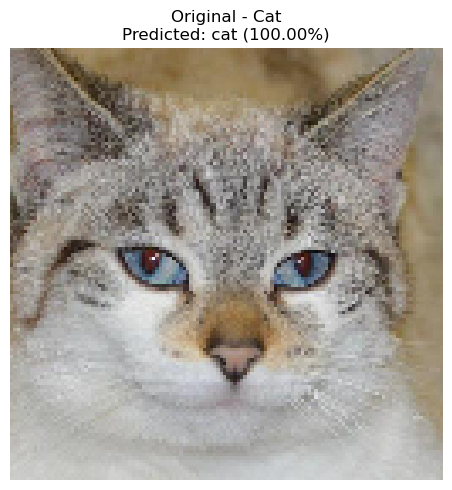

Blurred - Cat


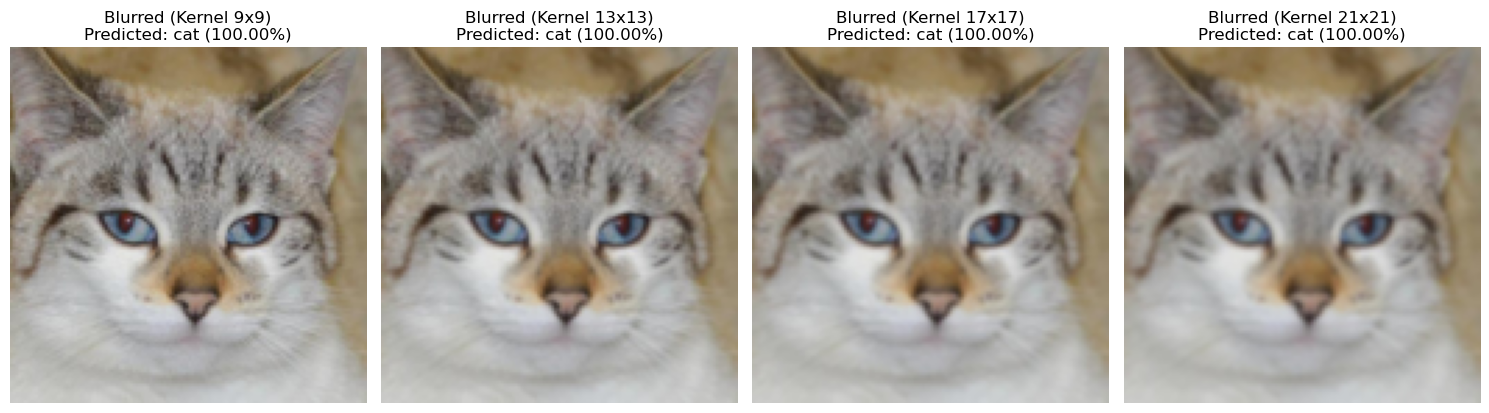

Brightened - Cat


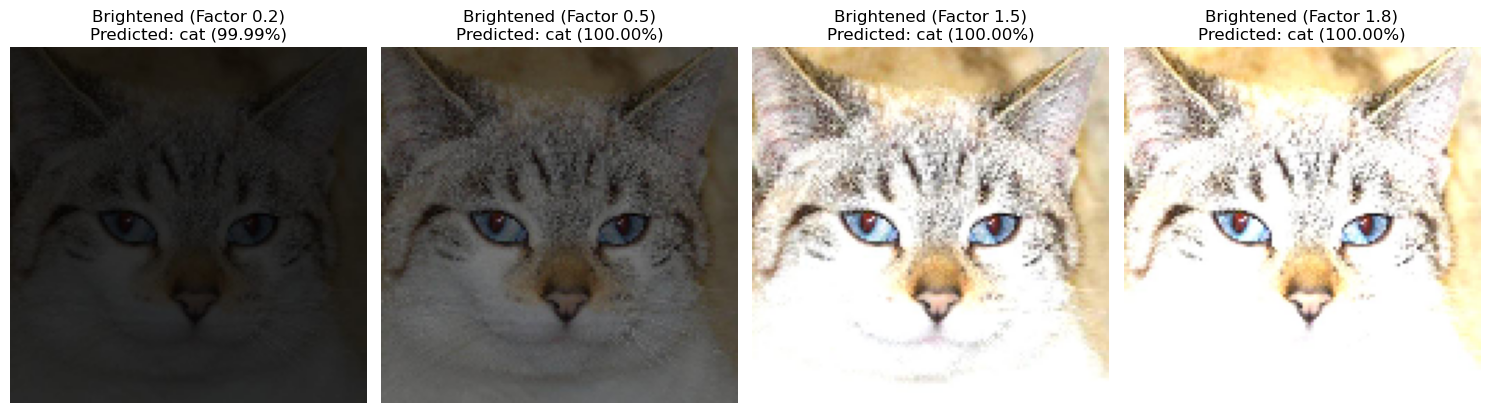

Rotated - Cat


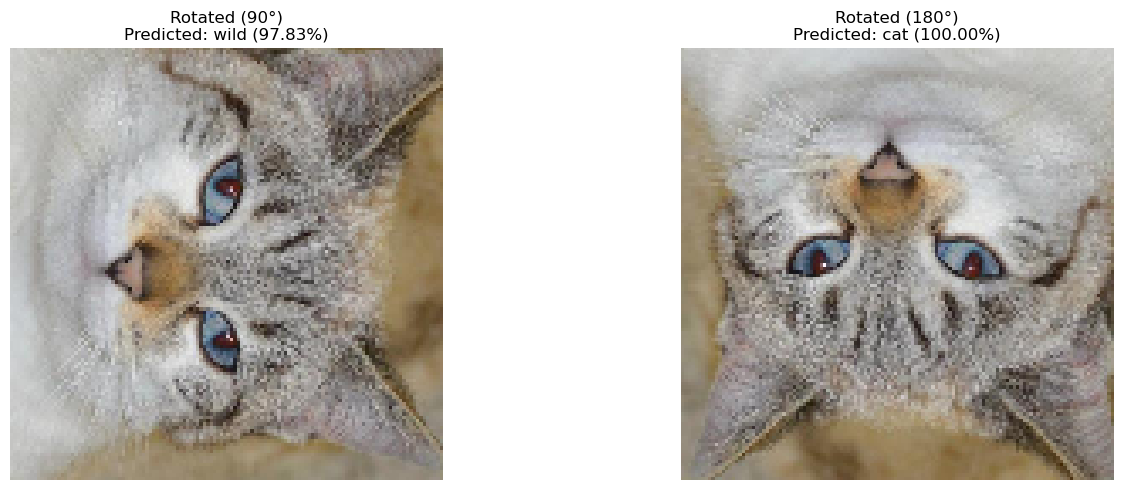

Noise - Cat


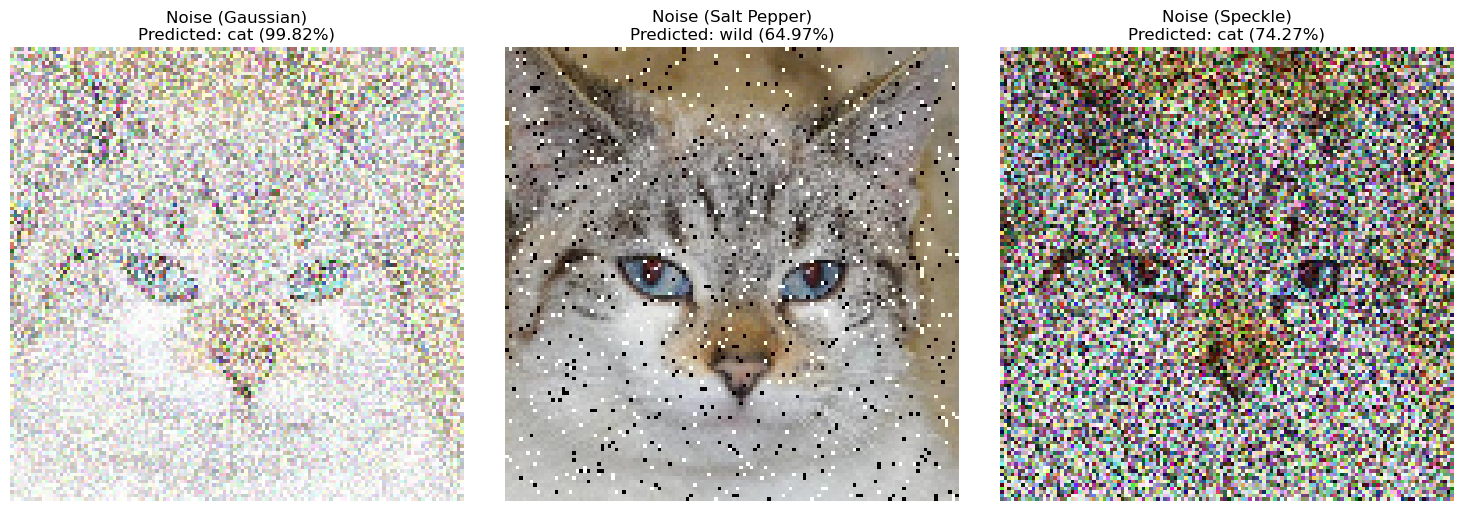

Original - Dog


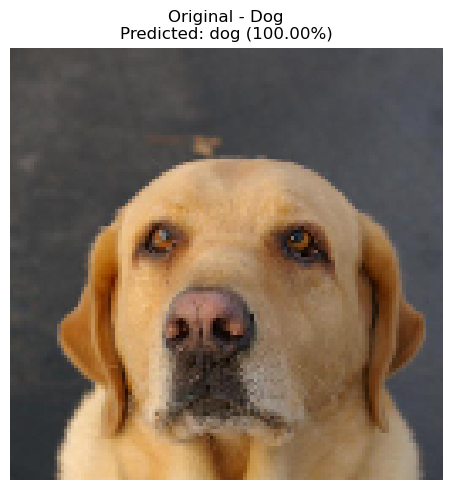

Blurred - Dog


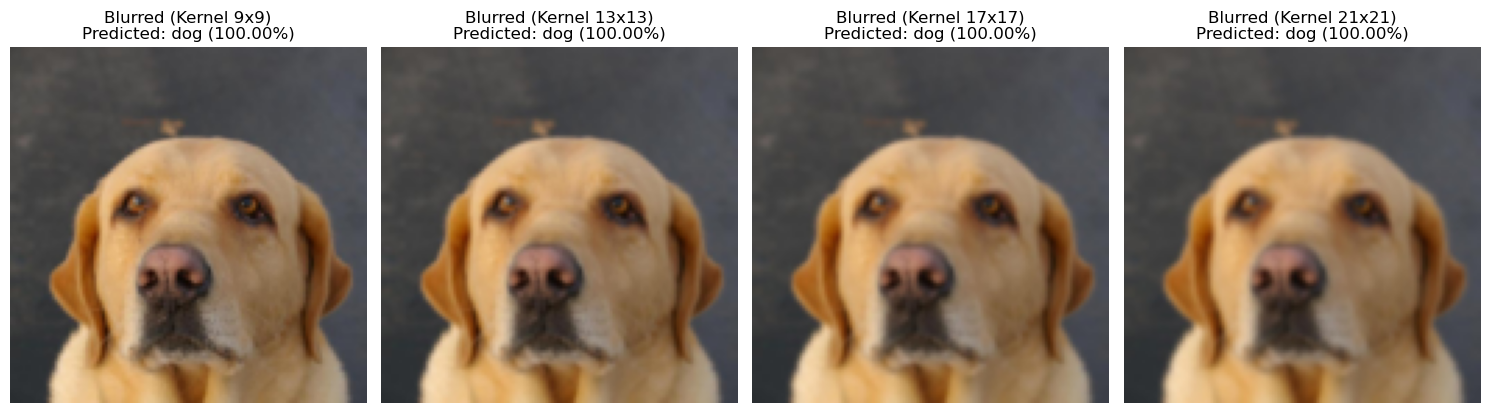

Brightened - Dog


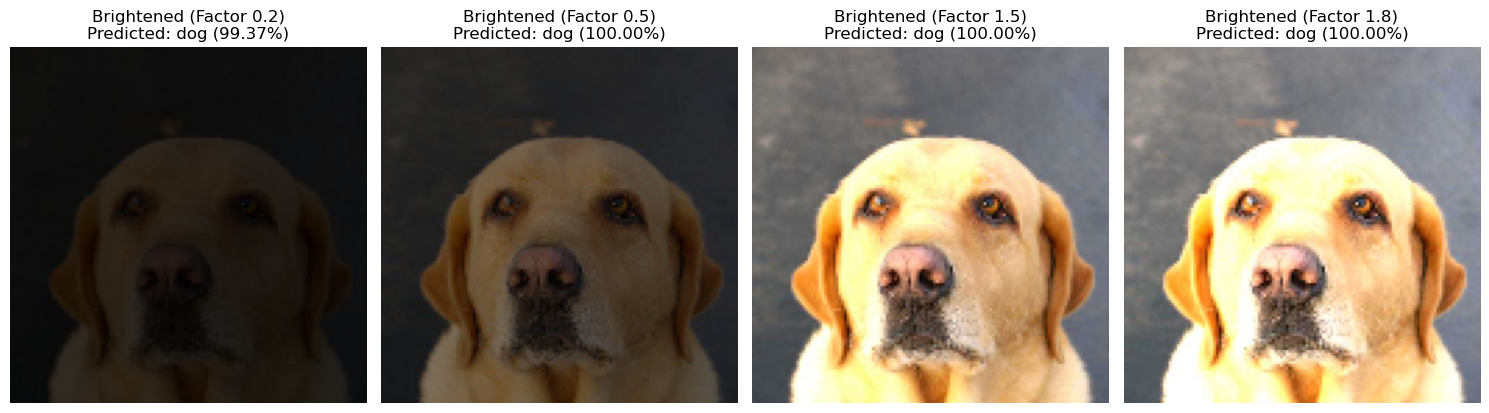

Rotated - Dog


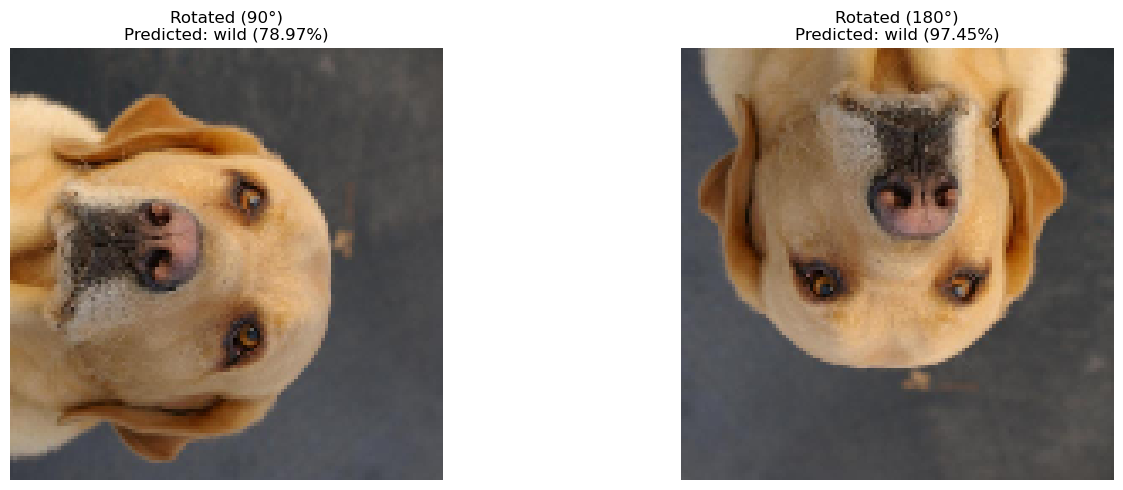

Noise - Dog


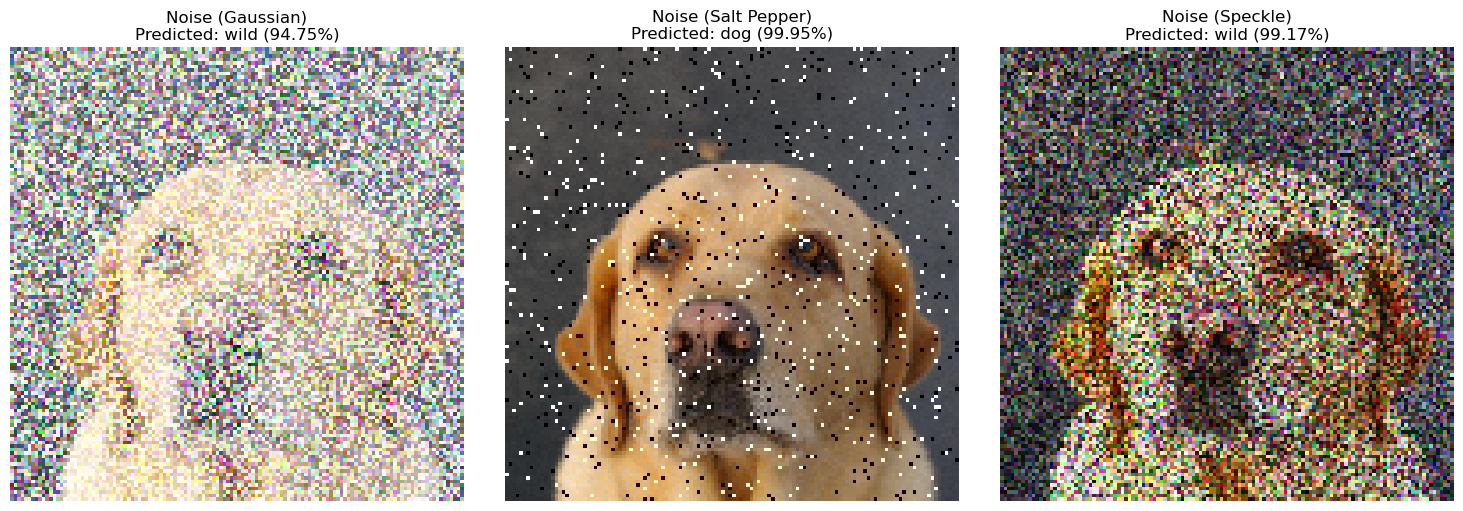

Original - Wild


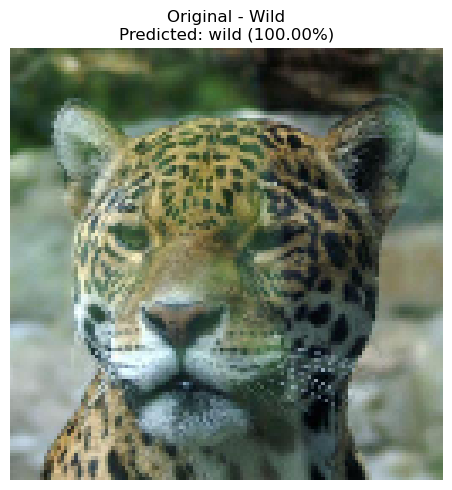

Blurred - Wild


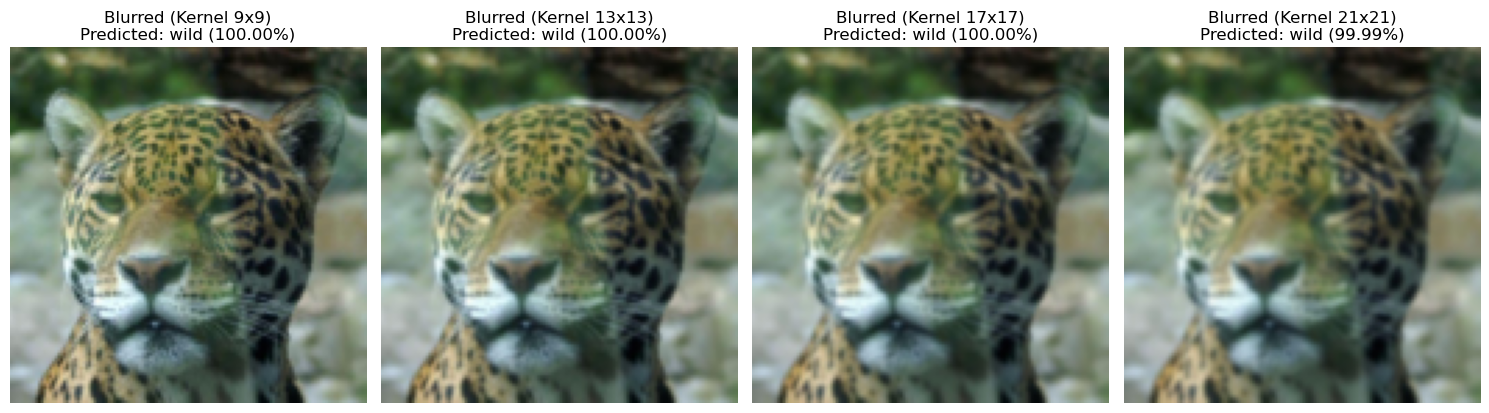

Brightened - Wild


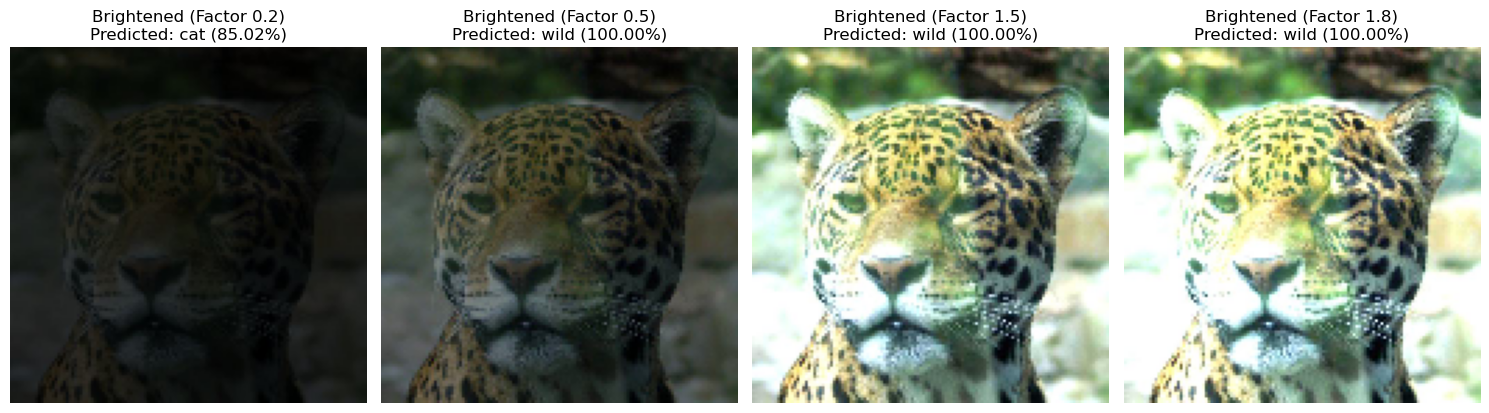

Rotated - Wild


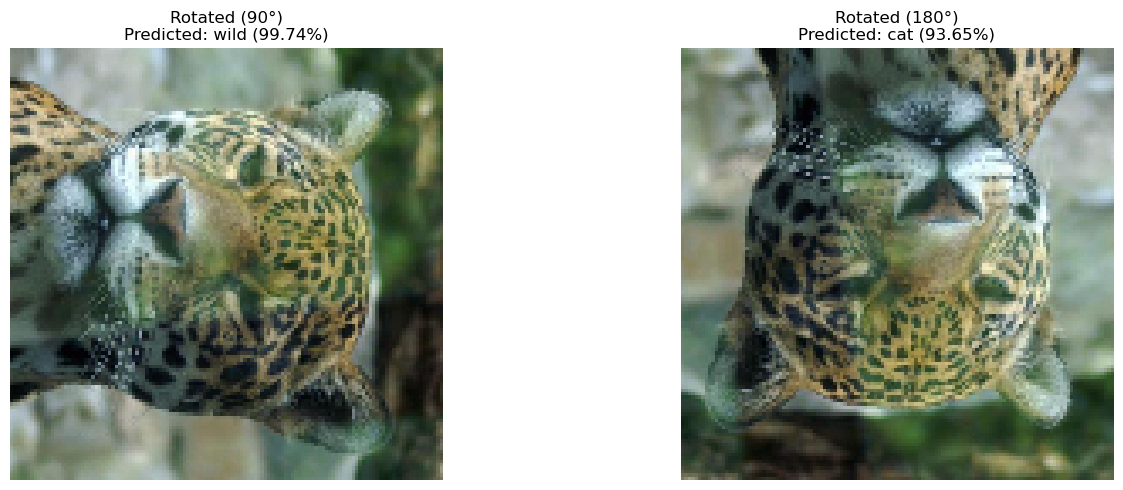

Noise - Wild


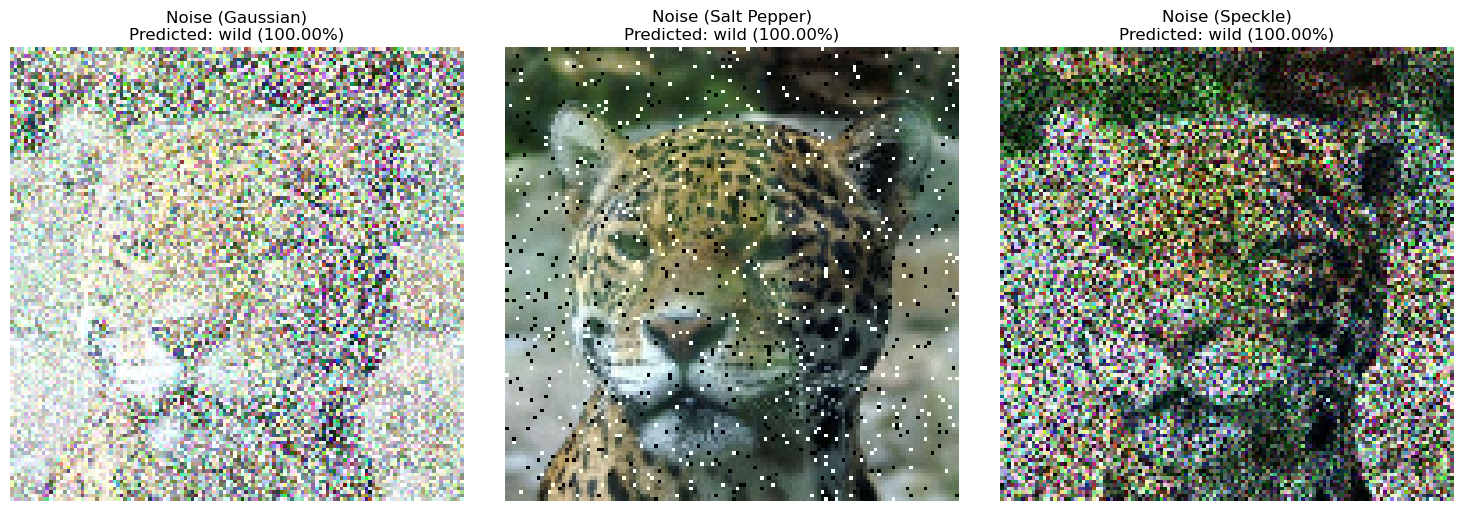

In [47]:
for category in categories:
    original_category_path = os.path.join(val_dir, category)
    random_filename = random.choice(os.listdir(original_category_path))

    original_image_path = os.path.join(original_category_path, random_filename)

    # Blurred
    blurred_images = []
    for kernel in transformation_params['blurred']:
        folder = f'blurred_{kernel[0]}x{kernel[1]}'
        filename = f'blurred_{kernel[0]}x{kernel[1]}_{random_filename}'
        blurred_images.append(os.path.join(transformed_dir, folder, category, filename))

    # Brightened
    brightened_images = []
    for factor in transformation_params['brightened']:
        folder = f'brightened_{factor}'
        filename = f'brightened_{factor}_{random_filename}'
        brightened_images.append(os.path.join(transformed_dir, folder, category, filename))

    # Rotated
    rotated_images = []
    for angle in transformation_params['rotated']:
        folder = f'rotated_{angle}'
        filename = f'rotated_{angle}_{random_filename}'
        rotated_images.append(os.path.join(transformed_dir, folder, category, filename))

    # Noise

    noise_prefix_map = {
    'gaussian': 'noisy_gaussian_std25',
    'salt_pepper': 'noisy_saltpepper',
    'speckle': 'noisy_speckle'
    }
        
    # Noise (match using known prefixes)
    noise_images = []
    noise_titles = []

    for noise_config in transformation_params['noise']:
        noise_type = noise_config['type']
        folder = f'noise_{noise_type}'
        folder_path = os.path.join(transformed_dir, folder, category)

        file_prefix = noise_prefix_map[noise_type]
        original_name = random_filename.lower()

        matching_file = next(
            (f for f in os.listdir(folder_path)
            if f.lower().startswith(file_prefix) and f.lower().endswith(original_name)),
            None
        )

        if matching_file:
            full_path = os.path.join(folder_path, matching_file)
            noise_images.append(full_path)
            noise_titles.append(f"Noise ({noise_type.replace('_', ' ').title()})")
        else:
            print(f"[Warning] No match found for noise type: {noise_type}")



    # Display
    print(f"Original - {category.capitalize()}")
    predict_and_display([original_image_path], [f"Original - {category.capitalize()}"])

    print(f"Blurred - {category.capitalize()}")
    predict_and_display(blurred_images, [f"Blurred (Kernel {k[0]}x{k[1]})" for k in transformation_params['blurred']])

    print(f"Brightened - {category.capitalize()}")
    predict_and_display(brightened_images, [f"Brightened (Factor {f})" for f in transformation_params['brightened']])

    print(f"Rotated - {category.capitalize()}")
    predict_and_display(rotated_images, [f"Rotated ({angle}°)" for angle in transformation_params['rotated']])

    print(f"Noise - {category.capitalize()}")
    predict_and_display(noise_images, [f"Noise ({n['type'].replace('_', ' ').title()})" for n in transformation_params['noise']])


##### **Summary**
In this project, we trained a Convolutional Neural Network (CNN) to classify animals into three categories — cat, dog, and wild — using clean and well-structured training and validation datasets.

To evaluate the model's robustness, we generated multiple transformed versions of the validation set, including:

- Blurred images with different kernel sizes
- Brightened images with various brightness levels
- Rotated images (90° and 180°)
- Noisy images with Gaussian, Salt & Pepper, and Speckle noise

We assessed model performance on both the original and transformed datasets to understand the impact of each type of distortion.

#### **Conclusion**
The model performs reliably on clean images and mild distortions like slight blurring or moderate brightness changes. As the transformations intensify, especially with rotation and noise, accuracy drops significantly — highlighting the model's limitations under real-world perturbations.

- Blurred images show a gradual decline in performance with increasing kernel size, but overall resilience is strong (only a ~1.5% dip).
- Brightness affects the model drastically at low levels (0.2), but performance rebounds at higher levels.
- Rotated images (especially 90°) lead to major confusion — the model lacks rotational invariance.
- Noise, particularly Gaussian and Speckle, causes noticeable degradation. Salt & Pepper is handled better, possibly due to its more localized effect.

These findings stress the need for data augmentation or robust architectures if the model is to be deployed in unpredictable environments.